In [2]:
!python --version

Python 2.7.13 :: Anaconda custom (x86_64)


(need to run this notebook using: jupyter notebook --NotebookApp.iopub_data_rate_limit=10000000000)

1. Take a square out of the center of each image equal to the shortest edge
1. Redimension the square so that all squares are of equal size
1. Reshape it into a tiling
1. Append the tiled arrays to a single DataFrame of width equal to the size of one tile as a 1D vector multiplied by 3 RGB channels
1. Run a 1D SOM on a random selection of the tiles (this will constitute the alphabet of the images)
1. Project them back to all the tiles
1. Reshape the array back into tiles where the BMU replaces the RGB pixels of each tile (this is the signature of each image).
1. Run another SOM


In [3]:
import random
from PIL import Image
import numpy as np
#%load_ext autotime
from matplotlib import pyplot as plt
%matplotlib inline
import sompylib.sompy as SOM
from sompylib.sompy import denormalize_by
import datetime

In [4]:
import glob
filelist = glob.glob("../profile-tweets-collections/2017_11/*.jpg")

In [5]:
length, width = 200, 200
crop_length, crop_width = 50, 50
portion_size = (length,width)

image_sq = []

for j in filelist:
    im = Image.open(j)
    if np.asarray(im).shape[0] > length and np.asarray(im).shape[1] > width and len(np.asarray(im).shape)==3:
        for x in range(0,300):
            image_size = im.size
            x1 = random.randint(0, image_size[0]-portion_size[0]-1)
            y1 = random.randint(0, image_size[1]-portion_size[1]-1)
            x2, y2 = x1+portion_size[0]-1, y1+portion_size[1]-1
            crop_rectangle = (x1, y1, x2, y2)
            cropped_im = im.crop(crop_rectangle)
            resize = cropped_im.resize((crop_length,crop_width))
            image_sq.append(np.asarray(resize)[:,:,:3].reshape(crop_length*crop_width*3))
            #image_sq.append(np.asarray(resize)[:,:].reshape(10000))
    else:
        print(np.asarray(im).shape)

(160, 314, 3)
(194, 452, 3)
(149, 1200, 3)
(153, 365, 3)
(153, 365, 3)
(153, 365, 3)
(153, 365, 3)
(142, 624, 3)
(200, 300, 3)
(196, 244, 3)
(196, 244, 3)
(100, 1200, 3)
(165, 800, 3)
(150, 300, 3)
(153, 365, 3)
(122, 217, 3)
(200, 300, 3)
(219, 164, 3)
(80, 80, 3)
(184, 244, 3)
(90, 90, 4)
(24, 64, 4)
(122, 220, 3)
(86, 88, 3)
(150, 350, 3)
(141, 243, 3)
(150, 350, 3)
(90, 215, 3)
(178, 470, 3)
(178, 1044, 3)
(266, 199, 3)
(183, 672, 3)
(180, 320, 3)
(80, 733, 3)
(151, 300, 3)
(151, 300, 3)
(151, 300, 3)
(61, 898, 3)
(120, 277, 3)
(128, 448, 3)
(172, 1200, 3)
(150, 350, 3)
(150, 350, 3)
(94, 220, 3)
(94, 220, 3)
(200, 300, 3)
(132, 1200, 3)
(58, 250, 3)
(24, 144, 4)
(175, 175, 3)


In [6]:
len(image_sq), image_sq[1].shape

(668700, (7500,))

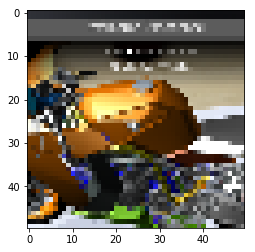

In [7]:
plt.imshow(image_sq[1].reshape(50,50,3))
#print(image_sq[1].reshape(50,50,3))

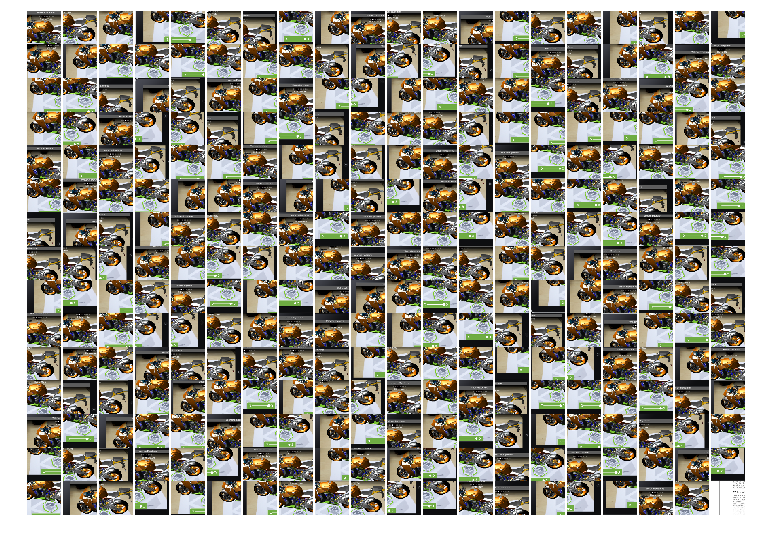

In [8]:
# Display the original tiles
w,h = 20,15
fig  = plt.figure(figsize=(10,10*h/w)) # (width, height)
c = 0;
for i in range(h):
    for j in range(w):
        ax = fig.add_subplot(15,20,c+1, aspect='equal') #laying down the height and then the width
        c = c+1
        fig.subplots_adjust(0,0,1,1,0,0)
        try:
            ax.imshow(image_sq[c].reshape(crop_length,crop_width,3))
            ax.axis('off')
        except: 
            ax.axis('off')
            pass

In [9]:
np.asarray(image_sq).shape

(668700, 7500)

In [10]:
# Prepare the global conditions for the SOM
import warnings
warnings.filterwarnings('ignore')

image_sq_arr = np.asarray(image_sq)

perc = 5
#som size, change to whatever you like?
msz0 = 50
msz1 = 50
images = image_sq_arr[np.random.choice(image_sq_arr.shape[0], int(float(perc)/100*image_sq_arr.shape[0]), replace=True), :]

# Run a SOM and extract the codebook
sm = SOM.SOM('', images, mapsize = [msz0, msz1],norm_method = 'var',initmethod='pca')
sm.init_map()
sm.train(trainlen=None, n_job = 1, shared_memory = 'no')#, verbose='on')
cb = sm.codebook[:]
cb_n = denormalize_by(sm.data_raw, sm.codebook[:], n_method='var')


initialization method = pca, initializing..

initialization done in 6.515000 seconds

rough training...
radius_ini: 7.000000 , radius_final: 1.750000, trainlen: 3

epoch: 1 ---> elapsed time:  21.259000, quantization error: 67.570165 

epoch: 2 ---> elapsed time:  21.383000, quantization error: 74.868946 

epoch: 3 ---> elapsed time:  21.705000, quantization error: 53.671025 


finetune training...
radius_ini: 1.750000 , radius_final: 1.000000, trainlen: 3

epoch: 1 ---> elapsed time:  21.387000, quantization error: 48.065167 

epoch: 2 ---> elapsed time:  23.269000, quantization error: 45.809247 

epoch: 3 ---> elapsed time:  28.716000, quantization error: 44.473619 

Total time elapsed: 145.196000 secodns
final quantization error: 44.473619


In [ ]:
# Project to the original data points
import pandas as pd
data = image_sq

sm.cluster_labels = np.asarray(["" for i in range(sm.nnodes)])
bmus = sm.project_data(data)
#im_bmus = pd.DataFrame(data)
#im_bmus['bmus'] = bmus
#im_bmus.head()

In [1]:
plt.imshow(cb_n[50].reshape(crop_length,crop_width,3)/255)

NameError: name 'plt' is not defined

NameError: name 'bmus' is not defined

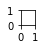

In [11]:
# Plotting the codebook
datetime.datetime.now()
fig  = plt.figure(figsize=(16,16))
c = 0;
for i in range(msz1):
    for j in range(msz0):
        #plt.subplot(msz0,msz1,c+1)
        ax = fig.add_subplot(msz0,msz1,c+1, aspect='equal')
        ind = bmus == c
        fig.subplots_adjust(0,0,1,1,0,0)
        try:
            ax.imshow(cb_n[c].reshape(crop_length,crop_width,3)/255)#,cmap='gray')
            ax.axis('off')
        except: 
            #ax.imshow(cb_n[c].reshape(50,50,3)/255)#.astype(float)/255)#,cmap='gray') ax.axis('off')
            ax.axis('off')
        else:
            ax.axis('off')
            pass
        c = c+1

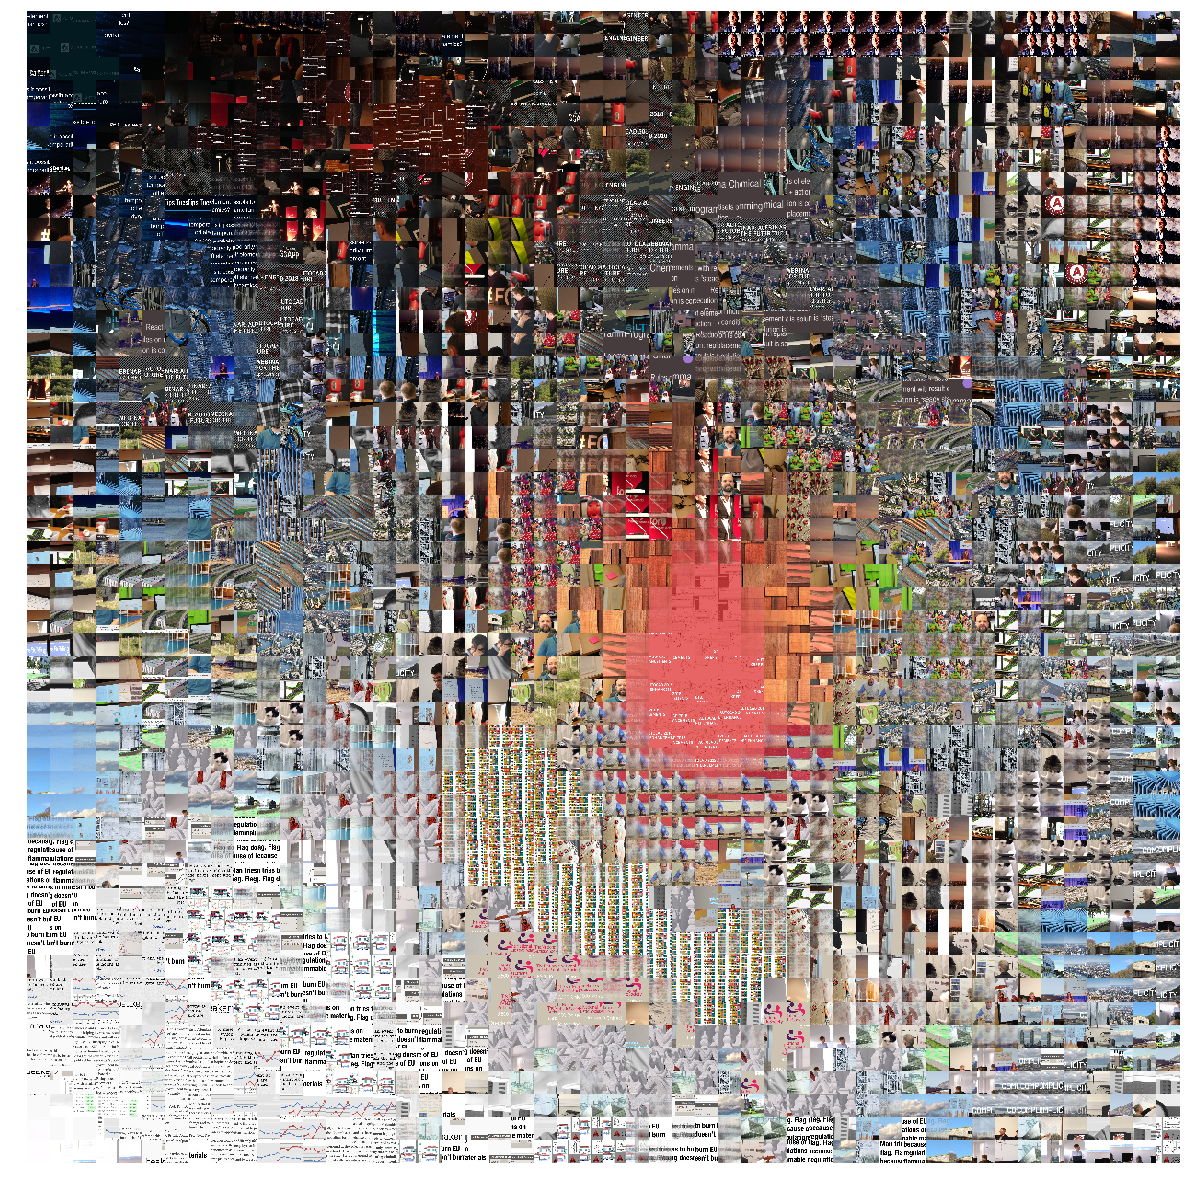

In [14]:
# Plotting the original tiles
datetime.datetime.now()
fig1  = plt.figure(figsize=(16,16))
c = 0;
for i in range(msz1):
    for j in range(msz0):
        #plt.subplot(msz0,msz1,c+1)
        ax = fig1.add_subplot(msz0,msz1,c+1, aspect='equal')
        ind = bmus == c
        fig1.subplots_adjust(0,0,1,1,0,0)
        try:
            ax.imshow(im_bmus[im_bmus['bmus']==c].sample(n=1).values[:,:crop_length*crop_width*3].reshape(crop_length,crop_width,3).astype(float)/255)#,cmap='gray')
            ax.axis('off')
        except: 
            ax.imshow(cb_n[c].reshape(crop_length,crop_width,3)/255)#.astype(float)/255)#,cmap='gray')
            ax.axis('off')
        else:
            ax.axis('off')
            pass
        c = c+1